## Music Genre Prediction (Multilabel Classification)

### Data
Source: https://dacon.io/competitions/official/236056/data
#### Train/Test Dataset
* Columns:
    * `ID`
    * Characteristics of each music sample
        * `danceability`
        * `energy`
        * `key`
        * `loudness`
        * `speechiness`
        * `acousticness` 
        * `instrumentalness`
        * `liveness`
        * `valence`
        * `tempo`
        * `duration`: duration of playtime (s)
    * `genre`: target label, genre of music (only included in train)
        * Underground Rap
        * Dark Trap
        * trance
        * Hiphop
        * trap
        * techhouse
        * techno
        * psytrance
        * hardstyle
        * dnb
        * RnB
        * Trap Metal
        * Rap
        * Emo
        * Pop
    
### Score Measures
* macro f1-score

In [ ]:
! pip install lightgbm==3.3.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.4 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import statsmodels as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras import layers
from keras import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from lightgbm import LGBMClassifier

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## EDA

In [ ]:
train.head()

,ID,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,genre
0,TRAIN_00000,0.3341,0.9231,10,0.8540,0.3797,0.0080,0.0002,0.7697,0.7902,0.5391,175,trap
1,TRAIN_00001,0.6344,0.5955,10,0.2826,0.1378,0.0000,0.7137,0.1597,0.4162,0.3043,513,techno
2,TRAIN_00002,0.3983,0.1107,8,0.2459,0.0247,0.7740,0.0000,0.5105,0.4291,0.2324,151,Trap Metal
3,TRAIN_00003,0.3139,0.9702,2,0.9252,0.9590,0.0371,0.3015,0.2539,0.0577,0.5406,246,trap
4,TRAIN_00004,0.0735,0.9452,5,0.7702,0.1397,0.2583,0.0015,0.1774,0.1128,0.3176,229,Dark Trap


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25383 entries, 0 to 25382
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                25383 non-null  object 
 1   danceability      25383 non-null  float64
 2   energy            25383 non-null  float64
 3   key               25383 non-null  int64  
 4   loudness          25383 non-null  float64
 5   speechiness       25383 non-null  float64
 6   acousticness      25383 non-null  float64
 7   instrumentalness  25383 non-null  float64
 8   liveness          25383 non-null  float64
 9   valence           25383 non-null  float64
 10  tempo             25383 non-null  float64
 11  duration          25383 non-null  int64  
 12  genre             25383 non-null  object 
dtypes: float64(9), int64(2), object(2)
memory usage: 2.5+ MB


In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
danceability,25383.0,0.544519,0.242362,0.0000,0.34050,0.5534,0.75990,1.0000
energy,25383.0,0.642106,0.275050,0.0000,0.41000,0.7013,0.89570,1.0000
key,25383.0,5.368239,3.660011,0.0000,1.00000,6.0000,9.00000,11.0000
loudness,25383.0,0.523904,0.209811,0.0000,0.37290,0.5383,0.68360,0.9995
speechiness,25383.0,0.271701,0.276586,0.0011,0.06295,0.1296,0.45020,1.0000
acousticness,25383.0,0.178736,0.272155,0.0000,0.00370,0.0358,0.23750,0.9999
instrumentalness,25383.0,0.309931,0.399725,0.0000,0.00000,0.0065,0.81400,1.0000
liveness,25383.0,0.324461,0.254626,0.0000,0.13810,0.2007,0.50150,1.0000
valence,25383.0,0.403999,0.286148,0.0000,0.14800,0.3618,0.64080,1.0000
tempo,25383.0,0.503558,0.222104,0.0073,0.32235,0.4835,0.65935,1.0000


15 genres


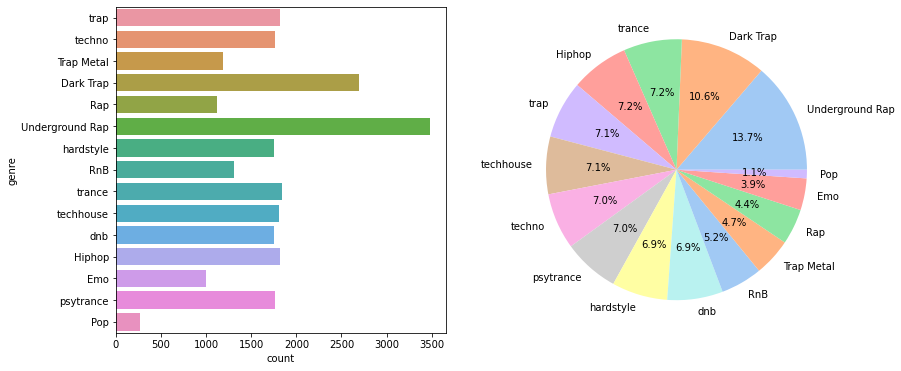

In [ ]:
print(len(train['genre'].unique()), "genres")
fig, axes = plt.subplots(1, 2, figsize=(13, 6))
sns.countplot(data=train, y=train['genre'], ax=axes[0])
palette_color = sns.color_palette('pastel')
train['genre'].value_counts().plot.pie(autopct="%1.1f%%", colors=palette_color, ax=axes[1]).set_ylabel('')
plt.show()

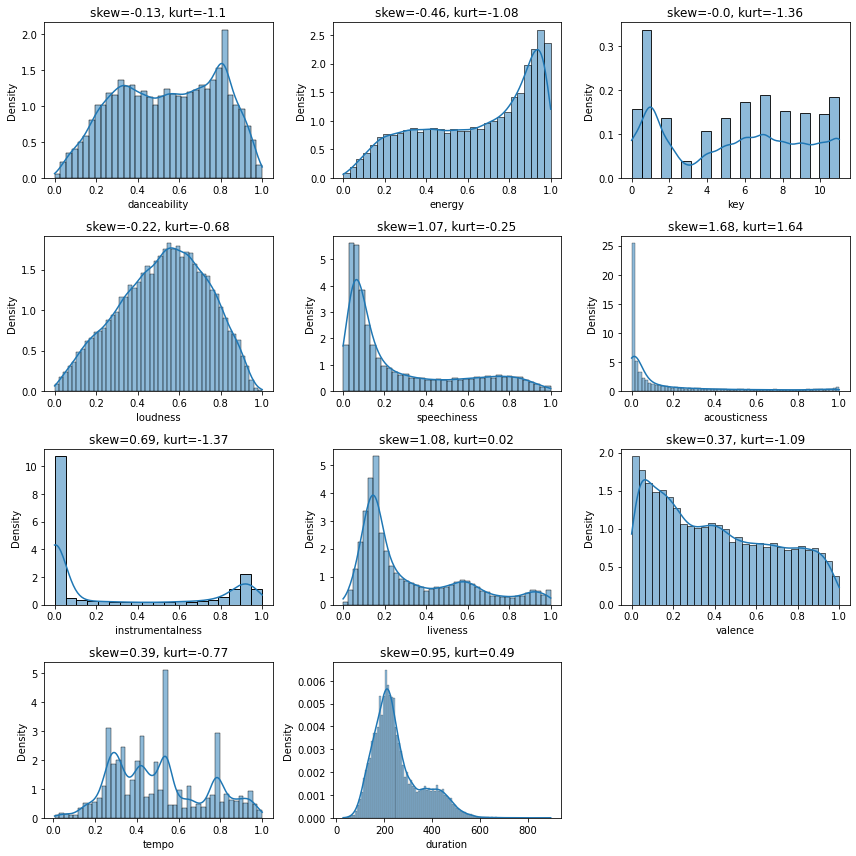

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(12, 12))
for col, ax in zip(train.select_dtypes(include=numerics), axes.flat):
    sns.histplot(train[col], kde=True, stat='density', ax=ax)
    skewness = round(train[col].skew(),2)
    kurtosis = round(train[col].kurt(),2)
    ax.set_title(f"skew={skewness}, kurt={kurtosis}")
axes[-1, -1].axis('off')
fig.tight_layout()

In [ ]:
display(train.groupby('genre').mean())

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration
genre,,,,,,,,,,,
Dark Trap,0.512007,0.469790,5.305638,0.417774,0.238043,0.285814,0.310013,0.281039,0.295730,0.514910,190.727374
Emo,0.316705,0.654143,4.916917,0.608114,0.141176,0.225858,0.011500,0.300685,0.507043,0.577007,221.924925
Hiphop,0.631817,0.474662,5.415477,0.485815,0.465246,0.348651,0.018975,0.322875,0.600511,0.654514,230.758507
Pop,0.602706,0.553132,5.481481,0.595988,0.163055,0.250776,0.009320,0.260271,0.655982,0.522069,212.703704
Rap,0.705367,0.413670,5.050000,0.489140,0.468854,0.330670,0.005785,0.287874,0.514668,0.330489,205.504464
RnB,0.597967,0.396946,5.070336,0.492348,0.290435,0.398968,0.009368,0.278909,0.574245,0.589416,228.669725
Trap Metal,0.562405,0.614032,4.645623,0.563554,0.429612,0.224094,0.065664,0.364328,0.392656,0.513014,150.559764
Underground Rap,0.710764,0.440472,5.111717,0.454234,0.475680,0.309531,0.028218,0.293828,0.514073,0.554015,178.934233
dnb,0.352288,0.810140,5.550029,0.703720,0.149165,0.040801,0.513014,0.303930,0.271439,0.781372,288.925100


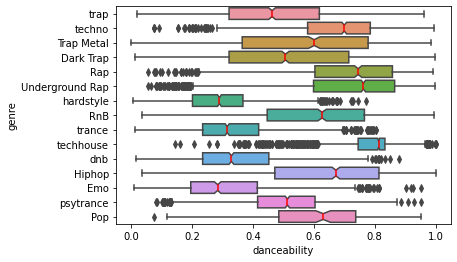

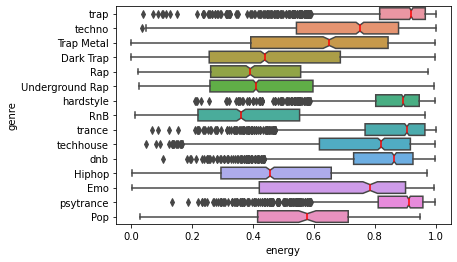

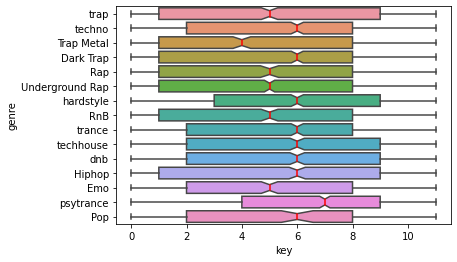

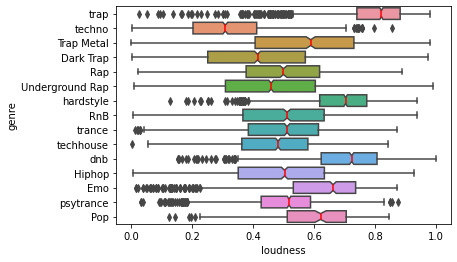

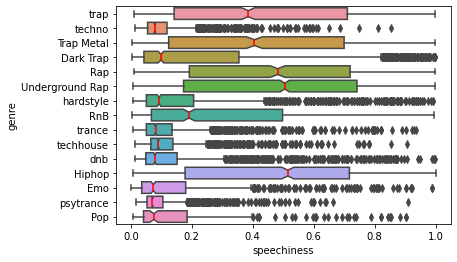

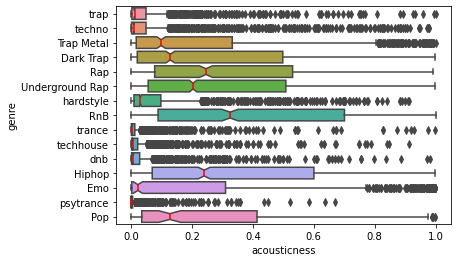

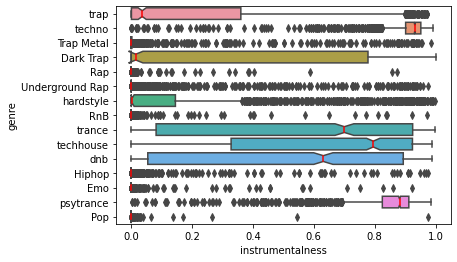

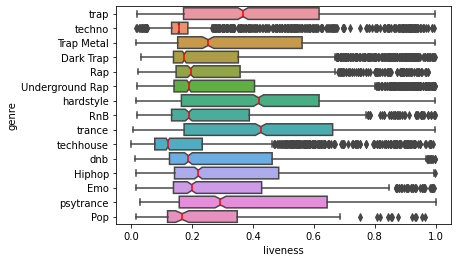

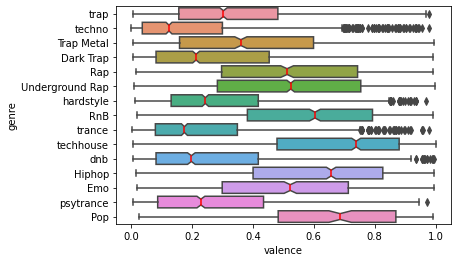

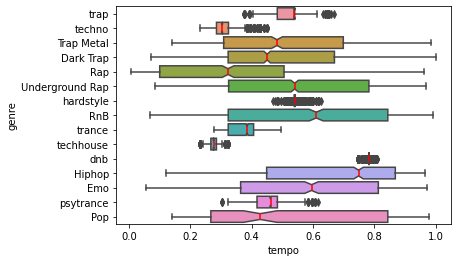

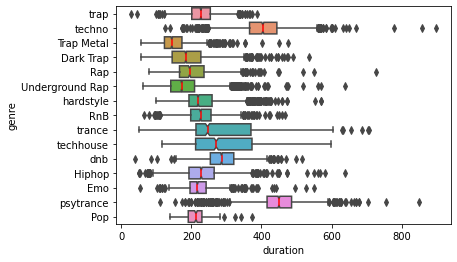

In [ ]:
for col in train.select_dtypes(include=numerics):
    sns.boxplot(x=col, y='genre', data=train, medianprops={"color":"red"}, notch=True)
    plt.show()

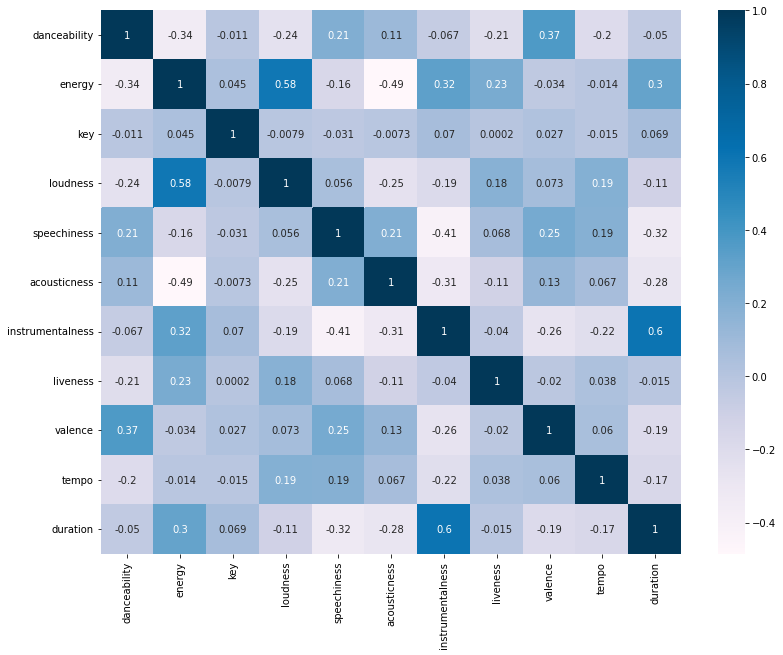

In [ ]:
plt.figure(figsize = (13, 10))
colormap = plt.cm.PuBu
sns.heatmap(train.corr(), annot = True, cmap = colormap)
plt.show()

## Preprocessing

In [ ]:
train.isnull().sum()

ID                  0
danceability        0
energy              0
key                 0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration            0
genre               0
dtype: int64

In [ ]:
# check multicollinearity
traindf = train.select_dtypes(include=numerics)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    traindf.values, i) for i in range(traindf.shape[1])]
vif["numeric features"] = traindf.columns
vif = vif.sort_values("VIF Factor", ascending=False).reset_index(drop=True)
vif

,VIF Factor,numeric features
0,16.881064,energy
1,14.073981,loudness
2,9.977039,duration
3,6.606693,danceability
4,5.893387,tempo
5,4.012017,valence
6,3.411897,instrumentalness
7,3.070403,key
8,2.788330,liveness
9,2.617589,speechiness


* energy & loudness seem dependent on each other. Exclude energy from prediction as it has higher VIF factor.

In [ ]:
# VIF after dropping energy
traindf = train.select_dtypes(include=numerics).drop(['energy'], axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    traindf.values, i) for i in range(traindf.shape[1])]
vif["numeric features"] = traindf.columns
vif = vif.sort_values("VIF Factor", ascending=False).reset_index(drop=True)
vif

,VIF Factor,numeric features
0,9.142920,duration
1,6.866137,loudness
2,6.305227,danceability
3,5.888670,tempo
4,3.861302,valence
5,3.058281,key
6,2.973974,instrumentalness
7,2.694413,liveness
8,2.604962,speechiness
9,1.638950,acousticness


In [ ]:
columns_drop = ['ID', 'energy']
train = train.drop(columns_drop, axis=1)
test = test.drop(columns_drop, axis=1)

In [ ]:
# oversampling
features = train.drop('genre', axis=1)
target = train['genre']

sampler=SMOTE()
ovsersampled_features, ovsersampled_target = sampler.fit_resample(features, target)

ovsersampled_features['genre'] = ovsersampled_target


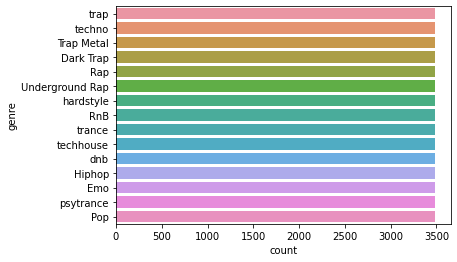

In [ ]:
sns.countplot(data=ovsersampled_features, y=ovsersampled_features['genre'])
plt.show()

* Performed oversampling since there is imbalance between the genres.

In [ ]:
train = ovsersampled_features

In [ ]:
# replace genre w/ number
le=LabelEncoder()
X=train.drop('genre',axis=1)
Y=le.fit_transform(train['genre'])

In [ ]:
le.classes_

array(['Dark Trap', 'Emo', 'Hiphop', 'Pop', 'Rap', 'RnB', 'Trap Metal',
       'Underground Rap', 'dnb', 'hardstyle', 'psytrance', 'techhouse',
       'techno', 'trance', 'trap'], dtype=object)

In [ ]:
dict(zip(le.inverse_transform(list(range(0, 15))), list(range(0, 15))))

{'Dark Trap': 0,
 'Emo': 1,
 'Hiphop': 2,
 'Pop': 3,
 'Rap': 4,
 'RnB': 5,
 'Trap Metal': 6,
 'Underground Rap': 7,
 'dnb': 8,
 'hardstyle': 9,
 'psytrance': 10,
 'techhouse': 11,
 'techno': 12,
 'trance': 13,
 'trap': 14}

In [ ]:
# scale
x = train.drop('genre', axis=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x)
X_test_scaled = scaler.transform(test)

## Model

### Keras model

In [ ]:
y_cat = to_categorical(Y)

# split train into train&val
X_train,X_test,y_train,y_test = train_test_split(X_train_scaled, y_cat, stratify=y_cat, test_size = 0.3,random_state = 42)

In [ ]:
model_1 = Sequential()
model_1.add(Dense(200, input_shape=(10,), activation='relu'))
model_1.add(Dense(100))
model_1.add(LeakyReLU(0.2))
model_1.add(Dense(15, activation='softmax'))
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               2200      
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 15)                1515      
                                                                 
Total params: 23,815
Trainable params: 23,815
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
history = model_1.fit(X_train, y_train, epochs=70, batch_size=128, validation_split = 0.3, callbacks=[es], verbose=1)

Epoch 1/70
200/200 [==============================] - 6s 15ms/step - loss: 1.4573 - accuracy: 0.5268 - val_loss: 1.1924 - val_accuracy: 0.5913
Epoch 2/70
200/200 [==============================] - 2s 10ms/step - loss: 1.1270 - accuracy: 0.6157 - val_loss: 1.0874 - val_accuracy: 0.6274
Epoch 3/70
200/200 [==============================] - 2s 9ms/step - loss: 1.0517 - accuracy: 0.6358 - val_loss: 1.0382 - val_accuracy: 0.6406
Epoch 4/70
200/200 [==============================] - 3s 17ms/step - loss: 1.0159 - accuracy: 0.6461 - val_loss: 1.0102 - val_accuracy: 0.6452
Epoch 5/70
200/200 [==============================] - 1s 7ms/step - loss: 0.9924 - accuracy: 0.6518 - val_loss: 0.9980 - val_accuracy: 0.6529
Epoch 6/70
200/200 [==============================] - 1s 5ms/step - loss: 0.9764 - accuracy: 0.6577 - val_loss: 0.9833 - val_accuracy: 0.6603
Epoch 7/70
200/200 [==============================] - 1s 5ms/step - loss: 0.9615 - accuracy: 0.6594 - val_loss: 0.9756 - val_accuracy: 0.6617
Epo

In [ ]:
y_pred = model_1.predict(X_test)
y_pred_class = y_pred.argmax(axis=-1)
y_test_class = np.argmax(y_test, axis=1)
print(classification_report(y_test_class, y_pred_class))

490/490 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.47      0.42      0.45      1045
           1       0.69      0.65      0.67      1044
           2       0.47      0.44      0.46      1045
           3       0.62      0.69      0.66      1044
           4       0.54      0.57      0.55      1045
           5       0.45      0.39      0.42      1044
           6       0.53      0.59      0.56      1044
           7       0.38      0.33      0.36      1045
           8       0.96      0.95      0.95      1045
           9       0.83      0.86      0.84      1044
          10       0.90      0.92      0.91      1045
          11       0.89      0.84      0.87      1045
          12       0.83      0.89      0.86      1045
          13       0.79      0.81      0.80      1045
          14       0.77      0.84      0.80      1044

    accuracy                           0.68     15669
   macro avg       0.67  

### LGBM

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train_scaled, Y, stratify=Y, test_size = 0.3,random_state = 42)

params={'n_estimators': 3000,
        'learning_rate': 0.009,
        'objective': 'multiclass',
        'random_state': 42,
        'num_class': 15}
clf = LGBMClassifier(**params)
clf.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.009, n_estimators=3000, num_class=15,
               objective='multiclass', random_state=42)

In [ ]:
lgbm_pred = clf.predict(X_test)
print(classification_report(y_test, lgbm_pred))

              precision    recall  f1-score   support

           0       0.56      0.51      0.53      1044
           1       0.84      0.83      0.84      1045
           2       0.59      0.51      0.55      1045
           3       0.84      0.92      0.88      1045
           4       0.65      0.71      0.68      1045
           5       0.64      0.62      0.63      1044
           6       0.60      0.66      0.63      1045
           7       0.38      0.37      0.37      1045
           8       0.98      0.98      0.98      1044
           9       0.92      0.92      0.92      1044
          10       0.96      0.94      0.95      1045
          11       0.93      0.93      0.93      1044
          12       0.92      0.92      0.92      1045
          13       0.88      0.91      0.89      1044
          14       0.89      0.90      0.89      1045

    accuracy                           0.78     15669
   macro avg       0.77      0.78      0.77     15669
weighted avg       0.77   

## Prediction

In [ ]:
# predict on unseen data. final score unknown
pred_class = clf.predict(X_test_scaled)
submission = pd.read_csv('sample_submission.csv')
submission['genre'] = le.inverse_transform(pred_class)
submission

,ID,genre
0,TEST_00000,Underground Rap
1,TEST_00001,Dark Trap
2,TEST_00002,Emo
3,TEST_00003,techhouse
4,TEST_00004,Pop
...,...,...
16917,TEST_16917,techhouse
16918,TEST_16918,Hiphop
16919,TEST_16919,hardstyle
16920,TEST_16920,psytrance


In [ ]:
submission.to_csv('sub.csv', index=False)

* macro f1-score for validation: 0.77
* Takeaways
    * performing oversampling on `genre` improves the performance of the model
    * we should consider multicollinearity in the data
    * it takes a long time to train & predict with an LGBM model (mabye b/c there are a lot of data and labels) but it shows good performance 
    * SVC also has potential for good predictions
    * maybe consider voting ensemble with more models in the future